# Traffic sign recongtion project

#### By Yaozhong Zhang  July 12, 2018

## Load data and visualize data

In [1]:
import pickle

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file,mode='rb') as f:
    train = pickle.load(f)
with open(validation_file,mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file,mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'],test['labels']

In [2]:
# Provide a basic summary of the data set

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)

image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)


28


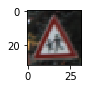

In [3]:
# visualize data

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## Pre-process and model architecture

In [4]:
# normalization!!!!!!!!!

X_train = (np.float32(X_train)-128)/128
X_valid = (np.float32(X_valid)-128)/128
X_test = (np.float32(X_test)-128)/128

#print(X_train[0])

In [5]:
# shuffle the training data

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [6]:
# set up TensorFlow
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

In [7]:
# Implement LeNet-5

"""
Architecture
Layer 1: Convolutional. The output shape should be 28x28x6.

Activation. Your choice of activation function.

Pooling. The output shape should be 14x14x6.

Layer 2: Convolutional. The output shape should be 10x10x16.

Activation. Your choice of activation function.

Pooling. The output shape should be 5x5x16.

Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

Layer 3: Fully Connected. This should have 120 outputs.

Activation. Your choice of activation function.

Layer 4: Fully Connected. This should have 84 outputs.

Activation. Your choice of activation function.

Layer 5: Fully Connected (Logits). This should have 10 outputs.
"""

from tensorflow.contrib.layers import flatten

def LeNet(x,keep_prob):
    
    mu = 0
    sigma = 0.11
    #Layer 1 convolutional Input 32x32x3
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,6),mean= mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_W,strides = [1,1,1,1],padding = 'VALID')
    conv1 = tf.nn.bias_add(conv1,conv1_b)
    
    conv1 = tf.nn.relu(conv1)
    
    #Pooling Input 28x28x6
    conv1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1],strides=[1,2,2,1],padding = 'SAME')
    
    #Layer 2 convolutional Input 14x14x6
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1,conv2_W,strides = [1,1,1,1],padding = 'VALID')
    conv2 = tf.nn.bias_add(conv2,conv2_b)
    
    conv2 = tf.nn.relu(conv2)
    
    #Pooling Input 10x10x16
    conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding = 'SAME')
    
    #Flatten Input 5x5x16
    flat = flatten(conv2)
    
    #Layer 3 Fully connectted Input 400
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(flat,fc1_W) + fc1_b
    
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1,keep_prob)
    
    #Layer 4 Fully connectted Input 120
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_W) + fc2_b
    
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2,keep_prob)
    
    #Layer 5 Fully connectted Input 84
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    fc3 = tf.matmul(fc2,fc3_W) + fc3_b
    
    logits = fc3
    
    return logits
    
    

In [8]:
# set features and labels

x = tf.placeholder(tf.float32,(None,32,32,3))
y = tf.placeholder(tf.int32,(None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y,43)

In [9]:
# training pipeline

rate = 0.0008

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
# Model Evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
# Train the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.550

EPOCH 2 ...
Validation Accuracy = 0.778

EPOCH 3 ...
Validation Accuracy = 0.836

EPOCH 4 ...
Validation Accuracy = 0.880

EPOCH 5 ...
Validation Accuracy = 0.891

EPOCH 6 ...
Validation Accuracy = 0.906

EPOCH 7 ...
Validation Accuracy = 0.913

EPOCH 8 ...
Validation Accuracy = 0.931

EPOCH 9 ...
Validation Accuracy = 0.937

EPOCH 10 ...
Validation Accuracy = 0.930

EPOCH 11 ...
Validation Accuracy = 0.940

EPOCH 12 ...
Validation Accuracy = 0.935

EPOCH 13 ...
Validation Accuracy = 0.942

EPOCH 14 ...
Validation Accuracy = 0.944

EPOCH 15 ...
Validation Accuracy = 0.941

EPOCH 16 ...
Validation Accuracy = 0.945

EPOCH 17 ...
Validation Accuracy = 0.949

EPOCH 18 ...
Validation Accuracy = 0.948

EPOCH 19 ...
Validation Accuracy = 0.957

EPOCH 20 ...
Validation Accuracy = 0.953

Model saved


In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.937


## Test model on new images

In [ ]:
# load and output the images
